In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import pickle

import torch
import torch.nn.functional as F

In [2]:
with uproot.open("../pythia/output/dataset_ttbarMG_mu60_NumEvents10k_MinJetpT25.root:fastjet") as f:
    jet_pt = f["jet_pt"].array()
    jet_eta = f["jet_eta"].array()
    jet_phi = f["jet_phi"].array()
    jet_corrJVF = f["jet_corrJVF"].array()
    jet_RpT = f["jet_RpT"].array()
    jet_m = f["jet_m"].array()
    trk_pt = f["trk_jet_pT"].array()
    trk_eta = f["trk_jet_eta"].array()
    trk_phi = f["trk_jet_phi"].array()
    trk_q = f["trk_jet_q"].array()
    trk_d0 = f["trk_jet_d0"].array()
    trk_z0 = f["trk_jet_z0"].array()
    trk_label = f["trk_jet_label"].array()
    jet_trk_IDX = f["jet_track_index"].array()
    jet_pufr_truth = f["jet_pufr_truth"].array()

In [3]:
%%time
#jet_feat_list = [jet_pt,jet_eta,jet_phi,jet_m,jet_corrJVF,jet_RpT,jet_pufr_truth]
jet_feat_list = [jet_pt,jet_eta,jet_phi,jet_m,jet_pufr_truth]

jet_feat_list = [x[:,:,np.newaxis] for x in jet_feat_list]
jet_feats = ak.concatenate(jet_feat_list, axis=2)

print("Num Events: ", len(jet_feats))
print("Num Jets in first event: ", len(jet_feats[0]))
print("Num Jet Features: ", len(jet_feats[0][0]))

Num Events:  10000
Num Jets in first event:  86
Num Jet Features:  5
CPU times: user 34.2 ms, sys: 317 μs, total: 34.5 ms
Wall time: 34.1 ms


In [4]:
%%time
trk_feat_list = [trk_pt,trk_eta,trk_phi,trk_q,trk_d0,trk_z0,trk_label]
trk_feat_list = [x[:,:,:,np.newaxis] for x in trk_feat_list]
trk_feats = ak.concatenate(trk_feat_list, axis=3)

print("Num Events: ", len(trk_feats))
print("Num Jets in first event: ", len(trk_feats[0]))
print("Num Tracks in first event first jet: ", len(trk_feats[0][0]))
print("Num Tracks features: ", len(trk_feats[0][0][0]))

Num Events:  10000
Num Jets in first event:  86
Num Tracks in first event first jet:  144
Num Tracks features:  7
CPU times: user 4.22 s, sys: 2.01 s, total: 6.24 s
Wall time: 6.24 s


In [5]:
jet_mask = abs(jet_feats[:,:,1])<4
selected_jets = jet_feats[jet_mask]
selected_tracks = trk_feats[jet_mask]

trk_q_cut = selected_tracks[:,:,:,3]!=0            # Skip neutral particles
trk_eta_cut = abs(selected_tracks[:,:,:,1])<4.5    # Skip forward region
trk_pt_cut = selected_tracks[:,:,:,0]>0.4          # 400MeV Cut

mask = trk_q_cut & trk_eta_cut & trk_pt_cut

selected_tracks = selected_tracks[mask]

In [6]:
# Skip trackless jets!
trackless_jets_mask = (ak.num(selected_tracks, axis=2)!=0)
selected_jets = selected_jets[trackless_jets_mask]
selected_tracks = selected_tracks[trackless_jets_mask]

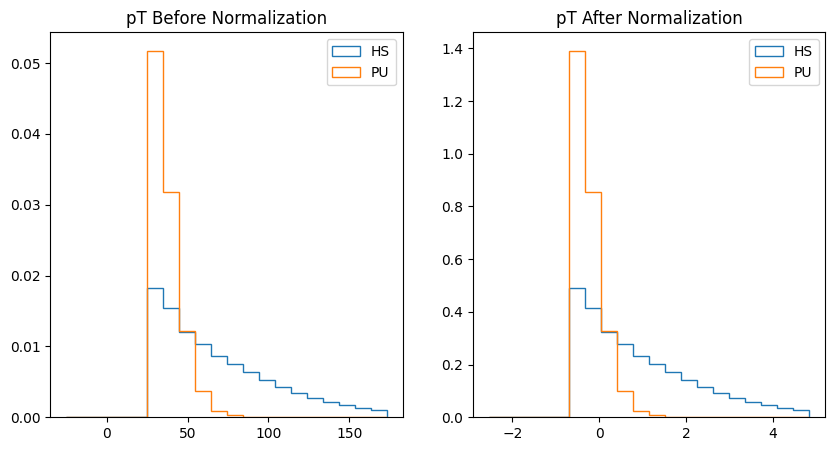

Mean Before:  43.10532733875267 		 Mean After:  -0.00018604872299030284
STD Before:  26.88390339961897 		 STD After:  1.0004231600862836


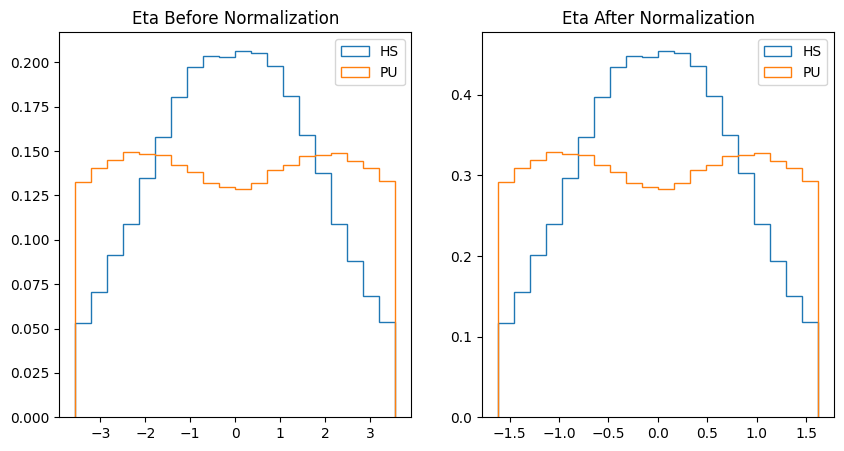

Mean Before:  0.00181889399696476 		 Mean After:  7.2488194283891e-09
STD Before:  2.2009500962208217 		 STD After:  1.0000785428320214


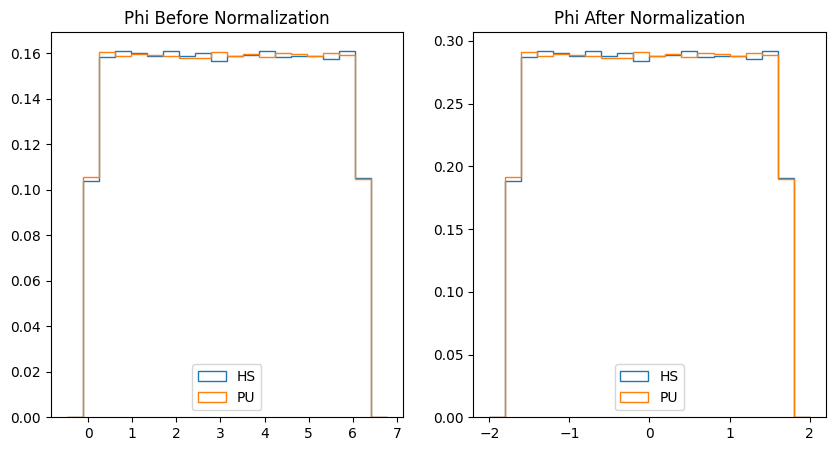

Mean Before:  3.142047509238281 		 Mean After:  2.199625846346732e-05
STD Before:  1.8139683159253621 		 STD After:  1.0002311969035567


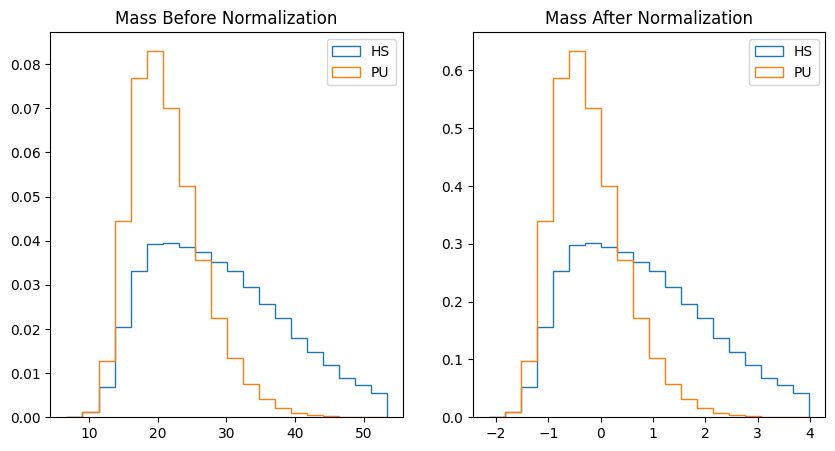

Mean Before:  22.92348331558843 		 Mean After:  -3.9359288272778195e-06
STD Before:  7.631943292464678 		 STD After:  1.0000067357126095


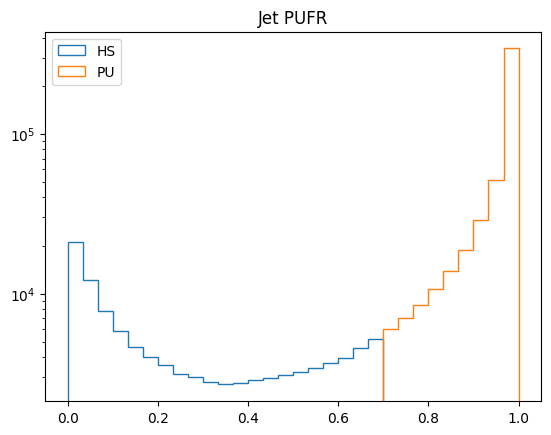

In [7]:
num_jet_feats = len(selected_jets[0][0])-1

sig = selected_jets[:,:,-1]<0.7
bkg = ~sig

var_list = ['pT','Eta','Phi','Mass']

# Normalize and Plot Jet Features
norm_list = []
for i in range(num_jet_feats):
    feat = selected_jets[:,:,i]
    mean = ak.mean(feat)
    std = ak.std(feat)
    norm = (feat-mean)/std
    norm_list.append(norm)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    mini=ak.mean(feat[sig])-2*ak.std(feat[sig])
    maxi=ak.mean(feat[sig])+2*ak.std(feat[sig])
    ax1.hist(ak.ravel(feat[sig]),label='HS',histtype='step',bins=20,range=(mini,maxi),density=True)
    ax1.hist(ak.ravel(feat[bkg]),label='PU',histtype='step',bins=20,range=(mini,maxi),density=True)
    ax1.set_title(var_list[i]+" Before Normalization")
    ax1.legend()
    mini=ak.mean(norm[sig])-2*ak.std(norm[sig])
    maxi=ak.mean(norm[sig])+2*ak.std(norm[sig])
    ax2.hist(ak.ravel(norm[sig]),label='HS',histtype='step',bins=20,range=(mini,maxi),density=True)
    ax2.hist(ak.ravel(norm[bkg]),label='PU',histtype='step',bins=20,range=(mini,maxi),density=True)
    ax2.set_title(var_list[i]+" After Normalization")
    ax2.legend()
    plt.show()
    print("Mean Before: ", mean, "\t\t Mean After: ", ak.mean(norm))
    print("STD Before: ", std, "\t\t STD After: ", ak.std(norm))

plt.title("Jet PUFR")
plt.hist(ak.ravel(selected_jets[:,:,-1][sig]),histtype='step',label='HS',bins=30,range=(0,1))
plt.hist(ak.ravel(selected_jets[:,:,-1][bkg]),histtype='step',label='PU',bins=30,range=(0,1))
plt.yscale('log')
plt.legend()
plt.show()    
    
# Append Labels
norm_list.append(selected_jets[:,:,-1])

Norm_list = [x[:,:,np.newaxis] for x in norm_list]
selected_jets = ak.concatenate(Norm_list, axis=2)

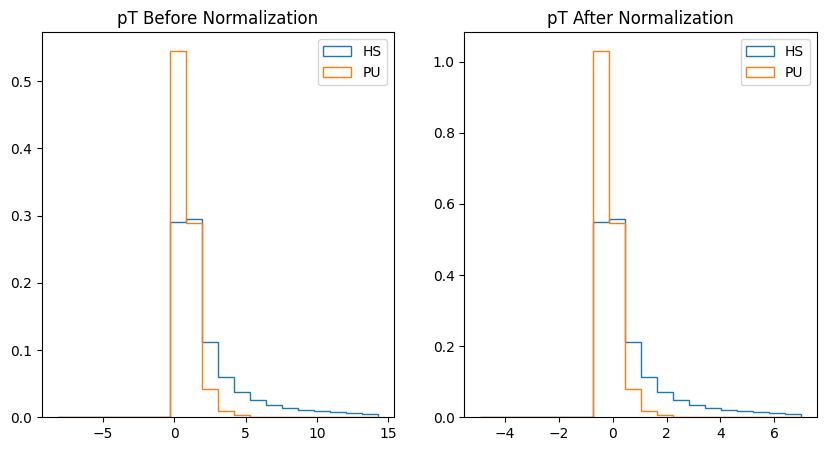

Mean Before:  1.0957994917567708 
Mean After:  -1.1971480496744287e-17
STD Before:  1.8895359459629637 
STD After:  0.9999999999997902


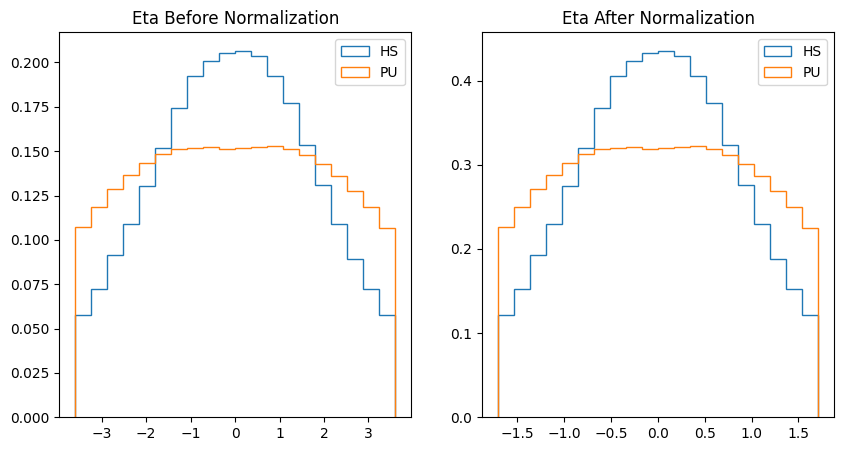

Mean Before:  0.0013822129225625804 
Mean After:  3.828313400558004e-18
STD Before:  2.1075161348219154 
STD After:  0.9999999999996809


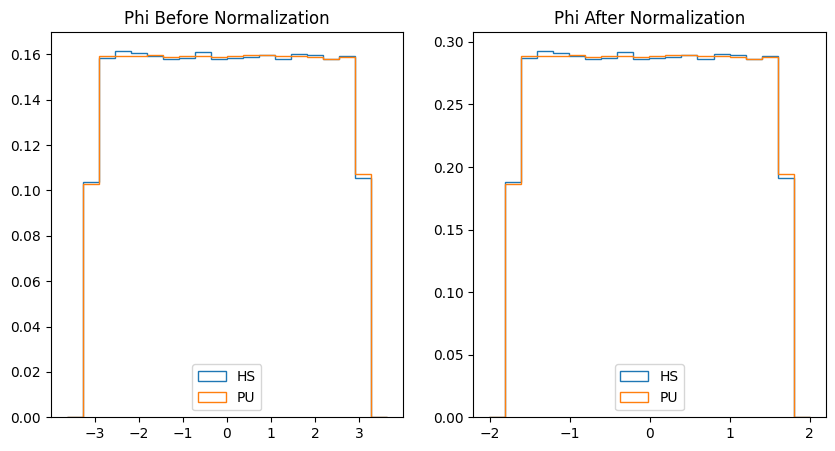

Mean Before:  -0.0009911924941859442 
Mean After:  2.4375361034619456e-17
STD Before:  1.8131910706604297 
STD After:  0.9999999999994306


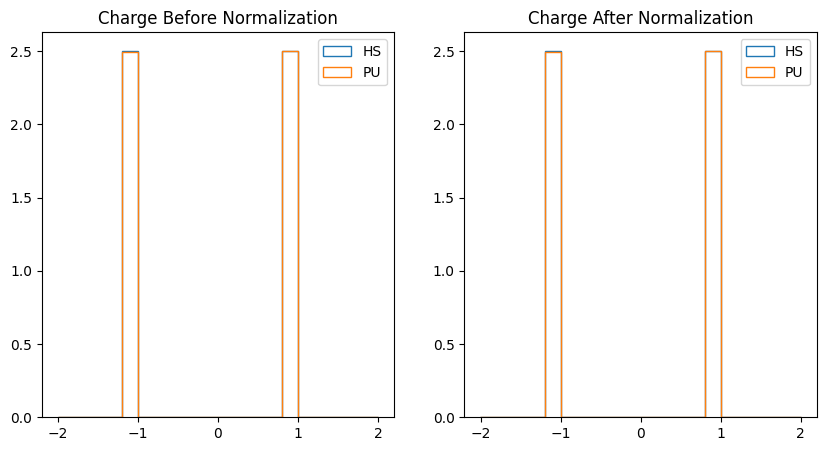

Mean Before:  0.0016620326579743915 
Mean After:  -1.435415405806155e-14
STD Before:  0.9999986188227681 
STD After:  0.9999999999722339


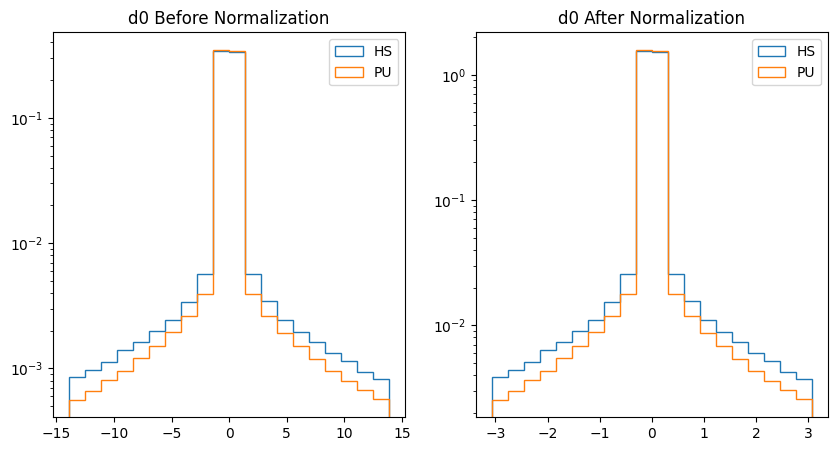

Mean Before:  0.0012724631966267187 
Mean After:  -4.5924312750720416e-17
STD Before:  4.529886919699889 
STD After:  0.999999999999861


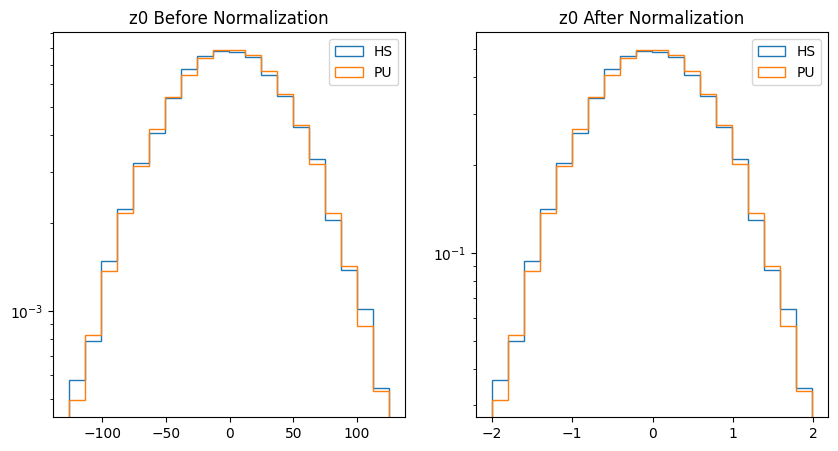

Mean Before:  0.10057628548085493 
Mean After:  4.0609454710251206e-17
STD Before:  63.27965133046212 
STD After:  0.9999999999996048


In [8]:
num_trk_feats = len(selected_tracks[0][0][0])-1

sig = selected_tracks[:,:,:,-1]==-1
bkg = ~sig

var_list = ['pT','Eta','Phi','Charge', 'd0', 'z0']

norm_list = []
for i in range(num_trk_feats):
    feat = selected_tracks[:,:,:,i]
    mean = ak.mean(feat)
    std = ak.std(feat)
    norm = (feat-mean)/std
    norm_list.append(norm)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    mini=ak.mean(feat[sig])-2*ak.std(feat[sig])
    maxi=ak.mean(feat[sig])+2*ak.std(feat[sig])
    ax1.hist(ak.ravel(feat[sig]),label='HS',histtype='step',bins=20,range=(mini,maxi),density=True)
    ax1.hist(ak.ravel(feat[bkg]),label='PU',histtype='step',bins=20,range=(mini,maxi),density=True)
    ax1.set_title(var_list[i]+" Before Normalization")
    ax1.legend()
    if '0' in var_list[i]:
        ax1.set_yscale('log')
    mini=ak.mean(norm[sig])-2*ak.std(norm[sig])
    maxi=ak.mean(norm[sig])+2*ak.std(norm[sig])
    ax2.hist(ak.ravel(norm[sig]),label='HS',histtype='step',bins=20,range=(mini,maxi),density=True)
    ax2.hist(ak.ravel(norm[bkg]),label='PU',histtype='step',bins=20,range=(mini,maxi),density=True)
    ax2.set_title(var_list[i]+" After Normalization")
    ax2.legend()
    if '0' in var_list[i]:
        ax2.set_yscale('log')
    plt.show()
    print("Mean Before: ", mean, "\nMean After: ", ak.mean(norm))
    print("STD Before: ", std, "\nSTD After: ", ak.std(norm))
    
# Add label
norm_list.append(selected_tracks[:,:,:,-1])
    
# Combine features
Norm_list = [x[:,:,:,np.newaxis] for x in norm_list]
selected_tracks = ak.concatenate(Norm_list, axis=3)

In [9]:
all_tracks = ak.flatten(selected_tracks, axis=2)

print("Jet Shape:\t", selected_jets.type)
print("Trk_Jet  Shape:\t", selected_tracks.type)
print("Trk_All Shape:\t", all_tracks.type)

Jet Shape:	 10000 * var * 5 * float64
Trk_Jet  Shape:	 10000 * var * var * 7 * float64
Trk_All Shape:	 10000 * var * 7 * float64


In [10]:
%%time
# Generate List of torch tensors on event by event basis
# Pad number of tracks per jet 

num_events = len(selected_jets)

Event_Data = []
Event_Labels = []

for event in range(num_events):
    if event%5==0:
        print("Processing: ", event, " / ", num_events, end="\r")
    jets = torch.Tensor(selected_jets[event,:,:])
    
    num_trks = ak.num(selected_tracks[event], axis=1)
    max_num_trks = ak.max(num_trks)

    trk_list = []
    num_jets = len(selected_jets[event])
    for jet in range(num_jets):
        tracks = torch.Tensor(selected_tracks[event][jet,:])        
        pad = (0,0,0,max_num_trks-len(tracks))        
        tracks = F.pad(tracks,pad)
        trk_list.append(torch.unsqueeze(tracks,dim=0))
    tracks = torch.cat(trk_list,dim=0)
    
    # Append all data but don't include label 0:-1!
    flat_tracks = torch.Tensor(all_tracks[event][:,0:-1])
    Event_Data.append((jets[:,0:-1],tracks[:,:,0:-1],flat_tracks))
    #Event_Labels.append((jets[:,-1].reshape(-1,1),tracks[:,:,-1].reshape(-1,1)))
    Event_Labels.append(jets[:,-1].reshape(-1,1))

print("Processing: ", num_events, " / ", num_events)

Processing:  10000  /  10000
CPU times: user 8min 46s, sys: 753 ms, total: 8min 47s
Wall time: 8min 46s


In [11]:
train_split = int(0.7*num_events)  # 70% train
test_split = int(0.75*num_events)  #  5% val + 25% test

Event_List = list(zip(Event_Data, Event_Labels))

Events_training = Event_List[0:train_split]
Events_validation = Event_List[train_split:test_split]
Events_testing = Event_List[test_split:]

print("Processing: ", num_events, " / ", num_events)
print("Training Events: ", len(Events_training))
print("Validation Events: ", len(Events_validation))
print("Testing Events: ", len(Events_testing))

Processing:  10000  /  10000
Training Events:  7000
Validation Events:  500
Testing Events:  2500


In [12]:
#raise Exception("Stop!")

In [13]:
X_train, y_train = list(zip(*Events_training))
X_val, y_val = list(zip(*Events_validation))
X_test, y_test = list(zip(*Events_testing))

data = (X_train, y_train, X_val, y_val, X_test, y_test)

pickle.dump(data, open("datasets/data_ttbar_MG.pkl", "wb"))

In [14]:
print("X_train Indices Reference:")
print("\tNum Events: ", len(X_train))
print("\tNum Tensors: ", len(X_train[0]), "(Jet, trk-jet, flat trk)")
print("\tNum Jets: ", len(X_train[0][0]))
print("\tNum Trks per Jet: ", len(X_train[0][1][0]))
print("\tNum Flat Trks: ", len(X_train[0][2]))
print("\tNum Jet Feats: ", len(X_train[0][0][0]))
print("\tNum Trk Feats: ", len(X_train[0][1][0][0]))
print()
print("y_train Indices Reference:")
print("\tNum Events: ", len(y_train))
print("\tNum Jets: ", len(y_train[0]))

X_train Indices Reference:
	Num Events:  7000
	Num Tensors:  3 (Jet, trk-jet, flat trk)
	Num Jets:  72
	Num Trks per Jet:  38
	Num Flat Trks:  1601
	Num Jet Feats:  4
	Num Trk Feats:  6

y_train Indices Reference:
	Num Events:  7000
	Num Jets:  72
